In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from xgboost import XGBClassifier

# Titanic - Machine Learning from Disaster
### Kaggle Competitions

## Dataset and EDA

In [2]:
# Read the train dataset
titanic_data = pd.read_csv("/kaggle/input/titanic/train.csv", index_col = "PassengerId")
titanic_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
# Describe numerical features
titanic_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [5]:
# Separate features and target
titanic = titanic_data.drop(columns = "Survived")
survived = titanic_data.Survived

titanic.shape, survived.shape

((891, 10), (891,))

In [6]:
# Select numerical columns (float only)
numerical_column_selector = make_column_selector(dtype_include = "float64")
float_cols = numerical_column_selector(titanic)

float_cols

['Age', 'Fare']

In [7]:
# Select nominal categorical features
categorical_column_selector = make_column_selector(dtype_include = "object")
object_cols = categorical_column_selector(titanic)


# Number of unique entries in each column with categorical data
categorical_nunique = titanic[object_cols].nunique()
categorical_nunique

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [8]:
# Select ordinal categorical features
ordinal_column_selector = make_column_selector(dtype_include = "int64")
int_cols = ordinal_column_selector(titanic)


# Number of unique entries in each column with ordinal data
ordinal_nunique = titanic[int_cols].nunique()
ordinal_nunique

Pclass    3
SibSp     7
Parch     7
dtype: int64

In [9]:
# Select low cardinality categorical features
categorical_low_cardinality = categorical_nunique[categorical_nunique < 5].index.tolist()
categorical_low_cardinality

['Sex', 'Embarked']

In [10]:
# Read the test dataset
titanic_test = pd.read_csv("/kaggle/input/titanic/test.csv", index_col = "PassengerId")
titanic_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [11]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


`Age`, `Cabin` and `Embarked` have values in both train and test set; `Fare` has missing values in test set only

##### `Survived`

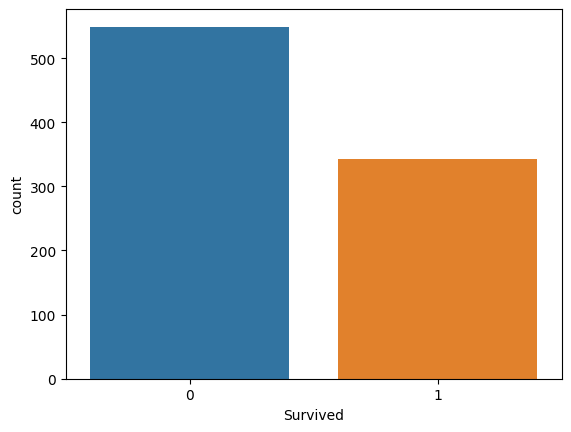

In [12]:
sns.countplot(data = titanic_data, x = "Survived")
plt.show()

##### `Pclass`

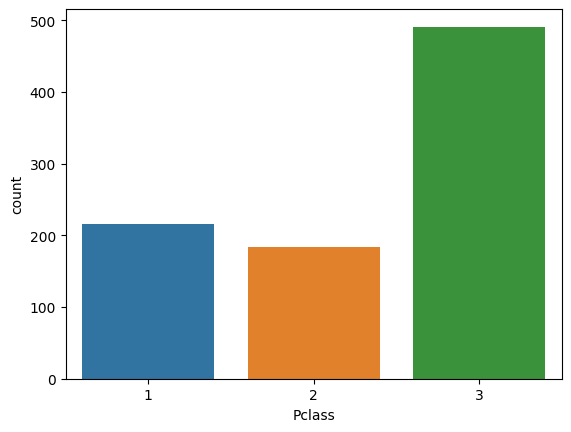

In [13]:
sns.countplot(data = titanic_data, x = "Pclass")
plt.show()

## Preprocessing

In [14]:
# Split the data into train and validation sets
titanic_train, titanic_val, survived_train, survived_val = train_test_split(
    titanic, 
    survived, 
    test_size = 0.3,
    random_state = 42
)


(titanic_train.shape, survived_val.shape), (titanic_val.shape, survived_val.shape)

(((623, 10), (268,)), ((268, 10), (268,)))

In [15]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = "median")),
    ('scaler', MinMaxScaler())
])

# Preprocessing for nominal categorical data
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('onehot', OneHotEncoder(drop = "if_binary", handle_unknown='ignore'))
])

# Preprocessing for ordinal categorical data
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('onehot', OneHotEncoder(drop = None, handle_unknown='ignore'))
])


# Join preprocessing for all types of data
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, float_cols),
        ('nominal', nominal_transformer, object_cols),
        ('ordinal', ordinal_transformer, int_cols),
        
    ])

## Model

In [16]:
# Define a model 
xgb = XGBClassifier(
#     early_stopping_rounds = 10, 
    random_state = 42
)

# Define grid search with cross-validation
xgb_grid = GridSearchCV(
    estimator = xgb,
    param_grid = {
        "n_estimators": [80, 100, 160, 200, 240],
        "learning_rate": [0.08, 0.1, 0.14, 0.18, 0.2, 0.24]
    },
    cv = 8,
    scoring = "accuracy"
)

In [17]:
# Fit the preprocessor, so that it could be used for the `eval_set`
preprocessor.fit(titanic)

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Fare']),
                                ('nominal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['Name', 'Sex', 'Ticket', 'Cabin',
                                  'Embarked']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Pclass', 'SibSp', 'Parch'])])

In [18]:
# Transform data
titanic_full_preprocessed = preprocessor.transform(titanic)
titanic_train_preprocessed = preprocessor.transform(titanic_train)
titanic_val_preprocessed = preprocessor.transform(titanic_val)
titanic_test_preprocessed = preprocessor.transform(titanic_test)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


 Warnings are expected - reason is the `drop` argument in OHE

In [19]:
xgb_grid.fit(
    titanic_full_preprocessed,
    survived, 
#     eval_set=[(titanic_val_preprocessed, survived_val)], 
#     verbose = False
)

GridSearchCV(cv=8,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.08, 0.1, 0.14, 0.18, 0.2, 0.24],
                         'n_estimators': [80, 100, 160, 200, 240]},
             scoring='accuracy')

In [20]:
# # Train the model 
# xgb.fit(
#     titanic_train_preprocessed,
#     survived_train, 
#     eval_set=[(titanic_val_preprocessed, survived_val)], 
#     verbose = False
# )

In [21]:
pd.DataFrame(xgb_grid.cv_results_)[["params", "mean_test_score", "rank_test_score"]]

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.08, 'n_estimators': 80}",0.814903,6
1,"{'learning_rate': 0.08, 'n_estimators': 100}",0.818271,3
2,"{'learning_rate': 0.08, 'n_estimators': 160}",0.820493,2
3,"{'learning_rate': 0.08, 'n_estimators': 200}",0.821610,1
4,"{'learning_rate': 0.08, 'n_estimators': 240}",0.817135,4
5,"{'learning_rate': 0.1, 'n_estimators': 80}",0.812631,14
6,"{'learning_rate': 0.1, 'n_estimators': 100}",0.812631,14
7,"{'learning_rate': 0.1, 'n_estimators': 160}",0.814883,8
8,"{'learning_rate': 0.1, 'n_estimators': 200}",0.814873,11
9,"{'learning_rate': 0.1, 'n_estimators': 240}",0.808136,25


In [22]:
best_model = xgb_grid.best_estimator_
best_model.score(titanic_train_preprocessed, survived_train)

0.942215088282504

In [23]:
best_model.score(titanic_full_preprocessed, survived)

0.9427609427609428

0.94276

##### Base scores

In [24]:
# Score for a model that predicts survival based on gender, female = survived
titanic_is_female = titanic_train.Sex.apply(lambda x: x == "female")
accuracy_score(survived_train, titanic_is_female)

0.7849117174959872

In [25]:
# Score for a model that predicts survival based on class, first class = survived
titanic_is_female = titanic_train.Pclass.apply(lambda x: x == "1")
accuracy_score(survived_train, titanic_is_female)

0.6292134831460674

## Submission

In [26]:
predictions = best_model.predict(titanic_test_preprocessed)

In [27]:
submission = pd.Series(predictions, index = titanic_test.index, name = "Survived")
submission

PassengerId
892     0
893     0
894     0
895     0
896     0
       ..
1305    0
1306    1
1307    0
1308    0
1309    1
Name: Survived, Length: 418, dtype: int64

In [28]:
submission.to_csv("submission.csv")

In [29]:
pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [30]:
pd.read_csv("submission.csv")

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
